In [128]:
%run init.ipynb
%run 08_gellmann.ipynb

# Recursos quânticos

## Coerência quântica
Mede a quantidade de superposição em relação aos autovetores de um observável (base ortonormal). Um exemplo seria a função baseada na norma $l_{1}$ (https://arxiv.org/abs/1609.02439):
$$C(\rho) = \sum_{j\ne k}|\rho_{j,k}|.$$

Como exemplo, consideremos o observável 
$$\sigma_{z} = |0\rangle\langle 0|-|1\rangle\langle 1|,$$
ou, de forma equivalente, a base ortonormal 
$$\{|0\rangle,|1\rangle\}.$$
Teremos
\begin{align}
& C(|0\rangle) = C(|1\rangle) = C(p_{0}|0\rangle\langle 0|+p_{1}|1\rangle\langle 1|) = 0, \\
& C(|+\rangle) = C(|-\rangle) = C(|\oplus\rangle) = C((|0\rangle+e^{i\phi}|1\rangle)/\sqrt{2}) = 1.
\end{align}

In [129]:
def coh_l1(rho):
    d = rho.shape[0]; C = 0
    for j in range(0,d-1):
        for k in range(j+1,d):
            C += np.abs(rho[j,k])
    return 2*C

In [130]:
rho = np.array([[1,0],[0,0]]); rho, coh_l1(rho)

(array([[1, 0],
        [0, 0]]),
 0)

In [131]:
rho = np.array([[1,1],[1,1]])/2; rho, coh_l1(rho)

(array([[0.5, 0.5],
        [0.5, 0.5]]),
 1.0)

## Informação mútua
Mede a quantidade total de correlações em um sistema bipartido (https://arxiv.org/abs/quant-ph/0410091):
$$I(\rho_{AB}) = S(\rho_{A}) + S(\rho_{B}) - S(\rho_{AB}),$$ 
em 
$$S(\rho)=-Tr(\rho\log_{2}(\rho))$$
é a entropia de von Neumann (https://doi.org/10.1590/S1806-11173711701). Usaremos também a entropia de Shannon de uma distribuição de probabilidades $\{p_{j}\}$:
$$H(\vec{p}) = -\sum_{j}p_{j}\log_{2}(p_{j}).$$

In [132]:
def mutual_info(da, db, rhoAB):
    rhoA = pTraceR_num(da, db, rhoAB); Sa = von_neumann_num(rhoA)
    rhoB = pTraceL_num(da, db, rhoAB); Sb = von_neumann_num(rhoB)
    Sab = von_neumann_num(rhoAB) 
    return Sa + Sb - Sab

In [133]:
def shannon_num(pv):
    d = pv.shape[0]; SE = 0.0; j = -1
    while (j < d-1):
        j = j + 1
        if pv[j] > 10**-15 and pv[j] < (1.0-10**-15):
            SE -= pv[j]*math.log(pv[j], 2)
    return SE

In [134]:
import scipy.linalg.lapack as lapak
def von_neumann_num(rho):
    d = rho.shape[0]; b = lapak.zheevd(rho)
    return shannon_num(b[0])

In [135]:
def pTraceL_num(dl, dr, rhoLR):
    rhoR = np.zeros((dr, dr), dtype=complex)
    for j in range(0, dr):
        for k in range(j, dr):
            for l in range(0, dl):
                rhoR[j,k] += rhoLR[l*dr+j,l*dr+k]
            if j != k:
                rhoR[k,j] = np.conj(rhoR[j,k])
    return rhoR
def pTraceR_num(dl, dr, rhoLR):
    rhoL = np.zeros((dl, dl), dtype=complex)
    for j in range(0, dl):
        for k in range(j, dl):
            for l in range(0, dr):
                rhoL[j,k] += rhoLR[j*dr+l,k*dr+l]
        if j != k:
            rhoL[k,j] = np.conj(rhoL[j,k])
    return rhoL

Como exemplos consideremos os estados 
$$|\Psi_{p}\rangle=|00\rangle,$$
$$\rho_{mc} = 0.5|00\rangle\langle 00|+0.5|11\rangle\langle 11|$$
e
$$|\Psi_{mq}\rangle = (|00\rangle+|11\rangle)/\sqrt{2}.$$

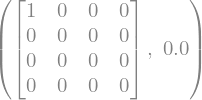

In [136]:
rho = proj(tp(cb(2,0),cb(2,0))); rho, mutual_info(2, 2, rho)

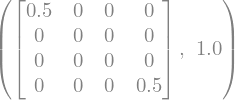

In [137]:
rho = 0.5*proj(tp(cb(2,0),cb(2,0))) + 0.5*proj(tp(cb(2,1),cb(2,1))); rho, mutual_info(2, 2, rho)

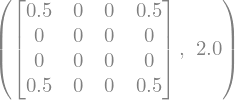

In [138]:
psi = (1/math.sqrt(2))*(tp(cb(2,0),cb(2,0))+tp(cb(2,1),cb(2,1)))
rho = proj(psi); rho, mutual_info(2, 2, rho)

## Discórdia quântica
É uma medida de correlações quânticas que mede a quantidade mínima de correlações que são destruídas por medidas não reveladas de observáveis locais. A definição original de Zurek é (https://arxiv.org/abs/1703.10542)
$$D_{A}(\rho_{AB}) = I(\rho_{AB})-\max_{\Pi_{A}}I(\Pi_{A}(\rho_{AB})),$$
em que 
$$\Pi_{A}(\rho_{AB}) = \sum_{j=1}^{d_{A}}\Pi_{j}^{A}\otimes I_{B}\rho_{AB}\Pi_{j}^{A}\otimes I_{B}.$$
De forma análoga, pode-se definir $D_{B}$ e $D_{AB}$.

Este problema de optimização não foi resolvido nem para estados gerais de 2 qubits. Existe uma fórmula analítica somente para estados do tipo X, com algumas controvérsias (https://arxiv.org/abs/1306.0228).

### Discórdia de Hellinger
É uma "boa" medida de discórdia quântica com solução analítica para sistemas $2\text{x}d$. Para um sistema qubit-qudit ($d_{a}=2$), para $Tr(\gamma_{j}\gamma_{k})=d\delta_{j,k}$, e para
\begin{equation}
\sqrt{\rho} = \frac{1}{\sqrt{d_{a}d_{b}}}\left(t_{0}\mathbb{I}_{a}\otimes\mathbb{I}_{b}+\vec{x}\cdot\vec{\sigma}\otimes\mathbb{I}_{b}+\mathbb{I}_{a}\otimes\vec{y}\cdot\vec{\gamma}+\sum_{j=1}^{d_{a}^{2}-1}\sum_{k=1}^{d_{b}^{2}-1}T_{j,k}\sigma_{j}\otimes\Gamma_{k}\right)
\end{equation}
temos (https://arxiv.org/abs/1510.06995)
\begin{equation}
    D_{A}^{he}(\rho)=2-2\sqrt{t_{0}^{2}+||\vec{y}||^{2}+k_{\max}},
\end{equation}
com $k_{\max}$ sendo o maior autovalor de 
$$K=\vec{x}\vec{x}^{T}+TT^{T}.$$ 
Para obtermos $D_{he}(\rho)\in[0,1]$, dividimos a expressão acima pelo seu valor máximo $2-2/\sqrt{d_{a}}$.

In [149]:
import scipy
def Dhellinger(da, db, rhoAB):
    M = scipy.linalg.sqrtm(rhoAB)
    A = pTraceR_num(da, db, M); bva = bloch_vector(A)/math.sqrt(2*db)
    B = pTraceL_num(da, db, M); bvb = bloch_vector(B)/2
    cm = corr_mat(da, db, M)/2; ev = lapak.zheevd(bva*bva.T + cm*cm.T)
    D_he = 2 - 2*math.sqrt((np.trace(A)/math.sqrt(2*db))**2 + (scipy.linalg.norm(bvb))**2 + max(ev[0].real))
    D_he = D_he/(2 - 2/math.sqrt(da))
    return D_he

In [150]:
da = 2; db = 2
M = scipy.linalg.sqrtm(np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]])/4)
A = pTraceR_num(2, 2, M); bva = bloch_vector(A)/math.sqrt(2*2); bva
B = pTraceL_num(da, db, M); bvb = bloch_vector(B)/2; bvb
cm = corr_mat(da, db, M)/2; ev = lapak.zheevd(bva*bva.T + cm*cm.T); cm
D_he = 2 - 2*math.sqrt((np.trace(A)/math.sqrt(2*db))**2 + (scipy.linalg.norm(bvb))**2 + max(ev[0].real))
D_he = D_he/(2 - 2/math.sqrt(da)); D_he

/tmp/ipykernel_298064/818443361.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  D_he = 2 - 2*math.sqrt((np.trace(A)/math.sqrt(2*db))**2 + (scipy.linalg.norm(bvb))**2 + max(ev[0].real))


In [ ]:
# teste para a raiz quadrada de matriz calculada usando scipy
A = np.array([[1,0],[0,-1]]); Asr = scipy.linalg.sqrtm(A); Asr # raiz quadrada (testes)
#Asr*Asr

## Emaranhamento quântico
Lembremos da decomposição de Schmidt. Estados puros não emaranhados, ou separáveis, são definidos por
$$|\Psi^{sep}\rangle = |\psi\rangle_{A}\otimes|\phi\rangle_{B}.$$
Para estados puros bipartidos, uma boa medida é a entropia de emaranhamento
$$E_{E}(|\Psi\rangle_{AB}) = S(\rho_{A}) = S(\rho_{B}),$$
com $\rho_{A}=Tr_{B}(|\Psi\rangle_{AB}\langle\Psi|)$ e o análogo para $\rho_{B}.$

Para estados mistos, bipartidos, estados separáveis são definidos por
$$\rho_{AB}^{sep} = \sum_{j}p_{j}\rho_{j}^{A}\otimes\rho_{j}^{B},$$
com $\{p_{j}\}$ sendo uma distribuição de probabilidades e $\rho_{j}^{A}$ e $\rho_{j}^{B}$ são operadores densidade válidos. Neste caso, podemos usar a decomposição em estados puros
$$\rho_{AB} = \sum_{j}p_{j}|\Psi_{j}\rangle_{AB}\langle\Psi_{j}|,$$
com $|\Psi_{j}\rangle_{AB}$ sendo estados puros válidos e $\{p_{j}\}$ é uma distribuição de probabilidades. Uma boa medida de emaranhamento neste caso é o __emaranhamento de formação__
$$E_{f}(\rho_{AB}) = \min_{\{p_{j},|\Psi_{j}\rangle_{AB}\}}\sum_{j}p_{j}E_{e}(|\Psi_{j}\rangle_{AB}).$$

Wootters resolveu este problema de optimização para 2 qubits, obtendo
$$E_{f}(\rho_{AB}) = H((1\pm\sqrt{1-E_{c}^{2}})/2)$$
e a concurrence é
$$E_{c} = E_{c}(\rho_{AB}) = \max(0,\sqrt{\lambda_{1}}-\sqrt{\lambda_{2}}-\sqrt{\lambda_{3}}-\sqrt{\lambda_{4}}$$
com $\{\lambda_{j}\}$ sendo os autovalores, arranjados em ordem decrescente, da matriz
$$R = \sqrt{\rho_{AB}}\tilde{\rho}_{AB}\sqrt{\rho_{AB}}$$
com
$$\tilde{\rho}_{AB} = (\sigma_{y}\otimes\sigma_{y})\rho_{AB}^{*}(\sigma_{y}\otimes\sigma_{y})$$
e $\rho_{AB}^{*}$ é o complexo conjugado de $\rho_{AB}$, calculado na base padrão.

In [112]:
def Pauli(j):
    if j == 0:
        return np.array([[1,0],[0,1]])
    elif j == 1:
        return np.array([[0,1],[1,0]])
    elif j == 2:
        return np.array([[0,-1j],[1j,0]])
    elif j == 3:
        return np.array([[1,0],[0,-1]])

In [ ]:
ev = lapak.zheevd(Pauli(1)); ev, ev[0], ev[0][0], ev[1][0], ev[1][0][0]

In [113]:
def Econcurrence(rho):
    R = rho@tp(Pauli(2),Pauli(2))@np.matrix.conjugate(rho)@tp(Pauli(2),Pauli(2))
    ev = lapak.zheevd(R)
    evm = max(abs(ev[0][0]), abs(ev[0][1]), abs(ev[0][2]), abs(ev[0][3]))
    Ec = 2*math.sqrt(abs(evm)) - math.sqrt(abs(ev[0][0])) - math.sqrt(abs(ev[0][1]))\
    - math.sqrt(abs(ev[0][2])) - math.sqrt(abs(ev[0][3]))
    if Ec < 0.0:
        Ec = 0.0
    return Ec

In [114]:
# Emaranhamento de formação
def Eof(rho):
    Ec = Econcurrence(rho)
    pv = np.zeros(2); pv[0] = (1+math.sqrt(1-Ec**2))/2; pv[1] = 1 - pv[0]
    return shannon_num(pv)

In [ ]:
pv=np.array([1,2]); pv.shape

Relação entre o emaranhamento de formação e a concurrence

In [ ]:
x = np.arange(10**-3,1,0.01); p0 = (1 + np.sqrt(1-x**2))/2; p1 = 1 - p0
ef = np.zeros(x.shape[0]); ef = -p0*np.log2(p0) - p1*np.log2(p1)
plt.plot(x , ef); plt.xlabel(r'$E_{c}$'); plt.ylabel(r'$E_{f}$'); plt.show()

## Estados de Werner de 1 qubits
$$\rho_{AB}^{w} = (1-w)\frac{I_{AB}}{4} + w|\Phi_{+}\rangle_{AB}\langle\Phi_{+}|.$$

In [160]:
def rho_werner(w):
    rho = np.zeros((4,4), dtype = complex)
    rho =+ ((1-w)/4)*np.identity(4) + (w/2)*np.array([[1,0,0,1],[0,0,0,0],[0,0,0,0],[1,0,0,1]])
    return rho
rho_werner(0)

array([[0.25, 0.  , 0.  , 0.  ],
       [0.  , 0.25, 0.  , 0.  ],
       [0.  , 0.  , 0.25, 0.  ],
       [0.  , 0.  , 0.  , 0.25]])

In [164]:
w = np.arange(0, 1.05, 0.05); C = np.zeros(w.shape[0]); MI = np.zeros(w.shape[0]); D_he = np.zeros(w.shape[0])
Ec = np.zeros(w.shape[0]); Ef = np.zeros(w.shape[0])
for j in range(0, w.shape[0]):
    rho = rho_werner(w[j]); C[j] = coh_l1(rho); MI[j] = mutual_info(2, 2, rho)/2
    D_he[j] = Dhellinger(2, 2, rho); Ec[j] = Econcurrence(rho); Ef[j] = Eof(rho)

/tmp/ipykernel_298064/4114336657.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  D_he = 2 - 2*math.sqrt((np.trace(A)/math.sqrt(2*db))**2 + (scipy.linalg.norm(bvb))**2 + max(ev[0].real))


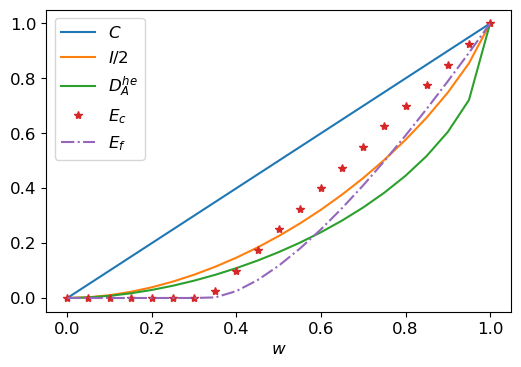

In [165]:
matplotlib.rcParams.update({'font.size':12})
plt.figure(figsize = (6,4), dpi = 100)
plt.plot(w, C, label = r'$C$'); plt.plot(w, MI, label = r'$I/2$'); 
plt.plot(w, D_he, label = r'$D_{A}^{he}$')
plt.plot(w, Ec, '*', label = r'$E_{c}$'); plt.plot(w, Ef, '-.', label = r'$E_{f}$')
plt.xlabel(r'$w$'); plt.legend(); plt.show()